In [21]:
import pandas as pd
df = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")
df_new = df.merge(store, on = "Store", how = "inner")
import numpy as np
df_new['Date'] = pd.to_datetime(df["Date"], infer_datetime_format = True)
df_new["Day"] = df_new["Date"].dt.day
df_new["Month"] = df_new["Date"].dt.month
df_new["Week"] = df_new["Date"].dt.week
df_new["Year"] = df_new["Date"].dt.year
df_new["Quarter"] = df_new["Date"].dt.quarter
# df_new.info()
# print(df_new.isnull().sum()/len(df_new)*100)
df_new["Promo2SinceWeek"] = df_new["Promo2SinceWeek"].fillna(
    df_new["Promo2SinceWeek"].mode()[0])
df_new["CompetitionDistance"] = df_new["CompetitionDistance"].fillna(
    df_new["CompetitionDistance"].mode()[0])
df_new["CompetitionOpenSinceMonth"] = df_new["CompetitionOpenSinceMonth"].fillna(
    df_new["CompetitionOpenSinceMonth"].mode()[0])
df_new["CompetitionOpenSinceYear"] = df_new["CompetitionOpenSinceYear"].fillna(
    df_new["CompetitionOpenSinceYear"].mode()[0])
df_new["Promo2SinceYear"] = df_new["Promo2SinceYear"].fillna(
    df_new["Promo2SinceYear"].mode()[0])
df_new["PromoInterval"] = df_new["PromoInterval"].fillna(
    df_new["PromoInterval"].mode()[0])
#print(df_new.isnull().sum()/len(df_new)*100)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
target = ["Sales"]
categorical_columns = ["DayOfWeek", "Quarter", "Month", "Year",
                      "StoreType", "Assortment"]
numerical_columns = ["Customers", "Open", "Promo", "Promo2",
                    "StateHoliday", "SchoolHoliday", 
                    "CompetitionDistance"]

def create_ohe(df, col):
    le = LabelEncoder()
    a = le.fit_transform(df[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse = False)
    column_names = [col + "_" + str(i) for i in le.classes_]
    return (pd.DataFrame(ohe.fit_transform(a), columns = 
                        column_names))
temp = df_new[numerical_columns]
for column in categorical_columns:
    temp_df = create_ohe(df_new, column)
    temp = pd.concat([temp, temp_df], axis = 1)
temp["StateHoliday"].unique()
temp["StateHoliday"] = np.where(temp["StateHoliday"] == '0',0,1)


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(temp, df_new["Sales"], 
                                                   random_state = 2019, test_size = 0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                   random_state = 2019, test_size = 0.1)

mean_sales = y_train.mean()
print(mean_sales)

mae = abs(y_test - mean_sales).mean()
print(mae)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories

5770.380903616925
2893.1482827058435


In [23]:

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History

history = History()

model_1 = Sequential()

model_1.add(Dense(150, input_dim = 40, activation = "relu"))
model_1.add(Dense(150, activation = "relu"))
model_1.add(Dense(150, activation = "relu"))
model_1.add(Dense(1, activation = "linear"))

model_1.compile(optimizer = 'adam', 
                loss = "mean_absolute_error",
               metrics = ["mean_absolute_error"])
model_1.fit(x_train, y_train, validation_data = (x_val,y_val),
           epochs = 10, batch_size = 64 , callbacks = [history])


Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 30s 42us/step - loss: 846.5657 - mean_absolute_error: 846.5657 - val_loss: 714.7126 - val_mean_absolute_error: 714.7126
Epoch 2/10
732390/732390 [==============================] - 30s 41us/step - loss: 724.4561 - mean_absolute_error: 724.4561 - val_loss: 699.0277 - val_mean_absolute_error: 699.0277
Epoch 3/10
732390/732390 [==============================] - 30s 41us/step - loss: 700.8747 - mean_absolute_error: 700.8747 - val_loss: 676.4772 - val_mean_absolute_error: 676.4772
Epoch 4/10
732390/732390 [==============================] - 31s 42us/step - loss: 685.7018 - mean_absolute_error: 685.7018 - val_loss: 839.8975 - val_mean_absolute_error: 839.8975
Epoch 5/10
732390/732390 [==============================] - 31s 42us/step - loss: 672.7050 - mean_absolute_error: 672.7050 - val_loss: 654.6262 - val_mean_absolute_error: 654.6262
Epoch 6/10
732390/732390 [=======================

Text(0, 0.5, 'Loss')

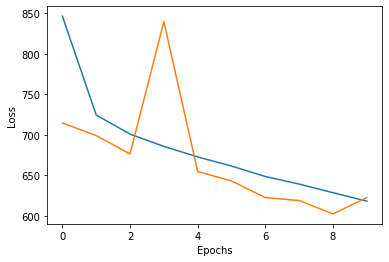

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [25]:
result = model_1.evaluate(x_test, y_test)
print(result)

203442/203442 [==============================] - 4s 20us/step
[626.7596318043953, 626.7596318043953]


In [26]:
history_m2 = History()

model_2 = Sequential()

model_2.add(Dense(350, input_dim = 40, activation = "relu"))
# model_1.add(Dense(150, activation = "relu"))
# model_1.add(Dense(150, activation = "relu"))
model_2.add(Dense(1, activation = "linear"))

model_2.compile(optimizer = 'adam', 
                loss = "mean_squared_error",
               metrics = ["mean_absolute_error"])
model_2.fit(x_train, y_train, validation_data = (x_val,y_val),
           epochs = 10, batch_size = 64 , callbacks = [history_m2])

Train on 732390 samples, validate on 81377 samples
Epoch 1/10
732390/732390 [==============================] - 18s 25us/step - loss: 2254312.9686 - mean_absolute_error: 954.6562 - val_loss: 1598346.1932 - val_mean_absolute_error: 876.6700
Epoch 2/10
732390/732390 [==============================] - 18s 25us/step - loss: 1473432.2889 - mean_absolute_error: 844.4409 - val_loss: 1365610.2211 - val_mean_absolute_error: 834.9088
Epoch 3/10
732390/732390 [==============================] - 18s 25us/step - loss: 1304261.2941 - mean_absolute_error: 803.4686 - val_loss: 1171897.1497 - val_mean_absolute_error: 759.6751
Epoch 4/10
732390/732390 [==============================] - 18s 24us/step - loss: 1210117.4609 - mean_absolute_error: 771.5605 - val_loss: 1185558.8601 - val_mean_absolute_error: 775.2690
Epoch 5/10
732390/732390 [==============================] - 18s 25us/step - loss: 1166641.1955 - mean_absolute_error: 754.1166 - val_loss: 1084599.6812 - val_mean_absolute_error: 727.5438
Epoch 6/1

Text(0, 0.5, 'Loss')

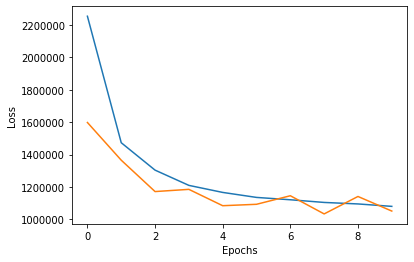

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history_m2.history['loss'])
plt.plot(history_m2.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [29]:
history_m3 = History()

model_3 = Sequential()

model_3.add(Dense(350, input_dim = 40, activation = "relu"))
model_3.add(Dense(350, activation = "relu"))
model_3.add(Dense(350, activation = "relu"))
model_3.add(Dense(350, activation = "relu"))
model_3.add(Dense(350, activation = "relu"))
model_3.add(Dense(1, activation = "linear"))

model_3.compile(optimizer = 'adam', 
                loss = "mean_squared_error",
               metrics = ["mean_absolute_error"])
model_3.fit(x_train, y_train, validation_data = (x_val,y_val),
           epochs = 15, batch_size = 64 , callbacks = [history_m3])

Train on 732390 samples, validate on 81377 samples
Epoch 1/15
732390/732390 [==============================] - 118s 162us/step - loss: 1656799.1410 - mean_absolute_error: 848.4872 - val_loss: 1171244.1569 - val_mean_absolute_error: 743.1520
Epoch 2/15
732390/732390 [==============================] - 118s 161us/step - loss: 1184749.6012 - mean_absolute_error: 731.8568 - val_loss: 1061990.2275 - val_mean_absolute_error: 704.8842
Epoch 3/15
732390/732390 [==============================] - 118s 161us/step - loss: 1090531.9158 - mean_absolute_error: 702.7046 - val_loss: 1023555.5733 - val_mean_absolute_error: 701.2409
Epoch 4/15
732390/732390 [==============================] - 118s 160us/step - loss: 1029283.3526 - mean_absolute_error: 682.1502 - val_loss: 962487.1996 - val_mean_absolute_error: 663.7247
Epoch 5/15
732390/732390 [==============================] - 119s 163us/step - loss: 974572.6014 - mean_absolute_error: 663.3894 - val_loss: 852526.4489 - val_mean_absolute_error: 622.0126
Ep

In [31]:
y_test_pred = model_2.predict(x_test)
mae = abs(y_test_pred - y_test).mean()
mse = ((y_test_pred - y_test)**2).mean()

MemoryError: 

Text(0, 0.5, 'Loss')

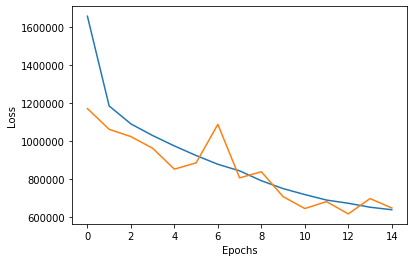

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history_m3.history['loss'])
plt.plot(history_m3.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [34]:
result = model_3.evaluate(x_test, y_test)
print(result)

203442/203442 [==============================] - 11s 56us/step
[657165.3533881892, 531.5513014252858]


In [35]:
model_3.save("rossman_model")

In [38]:
from keras.models import load_model
import pprint
pp = pprint.PrettyPrinter()
model_loaded = load_model("rossman_model")
j = model_loaded.to_json()
pp.pprint(j)

('{"class_name": "Sequential", "config": {"name": "sequential_4", "layers": '
 '[{"class_name": "Dense", "config": {"name": "dense_9", "trainable": true, '
 '"batch_input_shape": [null, 40], "dtype": "float32", "units": 350, '
 '"activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": '
 '"VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", '
 '"distribution": "uniform", "seed": null}}, "bias_initializer": '
 '{"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, '
 '"bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": '
 'null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": '
 '"dense_10", "trainable": true, "units": 350, "activation": "relu", '
 '"use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", '
 '"config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", '
 '"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, '
 '"kernel_regularizer":